In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import wordcloud
import Uncertainty as unc
import UncertaintyM as uncM
import matplotlib.pyplot as plt
import data_provider as dp
from classes.wordclouds import Wordcloud
from wordcloud import STOPWORDS
import random
random.seed(1)
np.random.seed(1)

In [2]:
episodes = 100
unc_embeddings = 100
random_runs = 1

test_split = 0.3
log = False
unc_plot = False
scaling = False
wordcloud_plot = False
seed = 1

In [3]:
# load the data
features_all, targets_all, text_all = dp.load_data("./Data/")
features_list, targets_list, text_list = dp.partition_data(features_all, targets_all, text_all, episodes) # make episodes

print(features_all.shape)
print(targets_all.shape)
print(len(text_all))

(7827594, 50)
(7827594, 2)
7911684


In [4]:
# Select only 1 and 5 star
for episode, (features, targets, texts) in enumerate(zip(features_list, targets_list, text_list)):
    texts = np.array(texts)
    print(f"------------------------------------ {episode} before")
    print(features.shape)
    print(targets.shape)
    print(len(texts))

    index = np.where(targets[:,0]==0)[0]
    features1 = features[index]
    targets1 = targets[index]
    texts1 = texts[index]

    index = np.where(targets[:,0]==4)[0]
    features5 = features[index]
    targets5 = targets[index]
    texts5 = texts[index]

    features = np.concatenate((features1,features5))
    targets  = np.concatenate((targets1,targets5))
    texts     = np.concatenate((texts1,texts5))

    features_list[episode] = features
    targets_list[episode] = targets
    text_list[episode] = texts

    print("------------------------------------ after")
    print(features.shape)
    print(targets.shape)
    print(len(texts))
    print(np.unique(targets[:,0]))

    break



------------------------------------ 0 before
(78275, 50)
(78275, 2)
78275
------------------------------------ after
(53110, 50)
(53110, 2)
53110
[0 4]


episode  0
------------------------------------ run  0
test count  15933


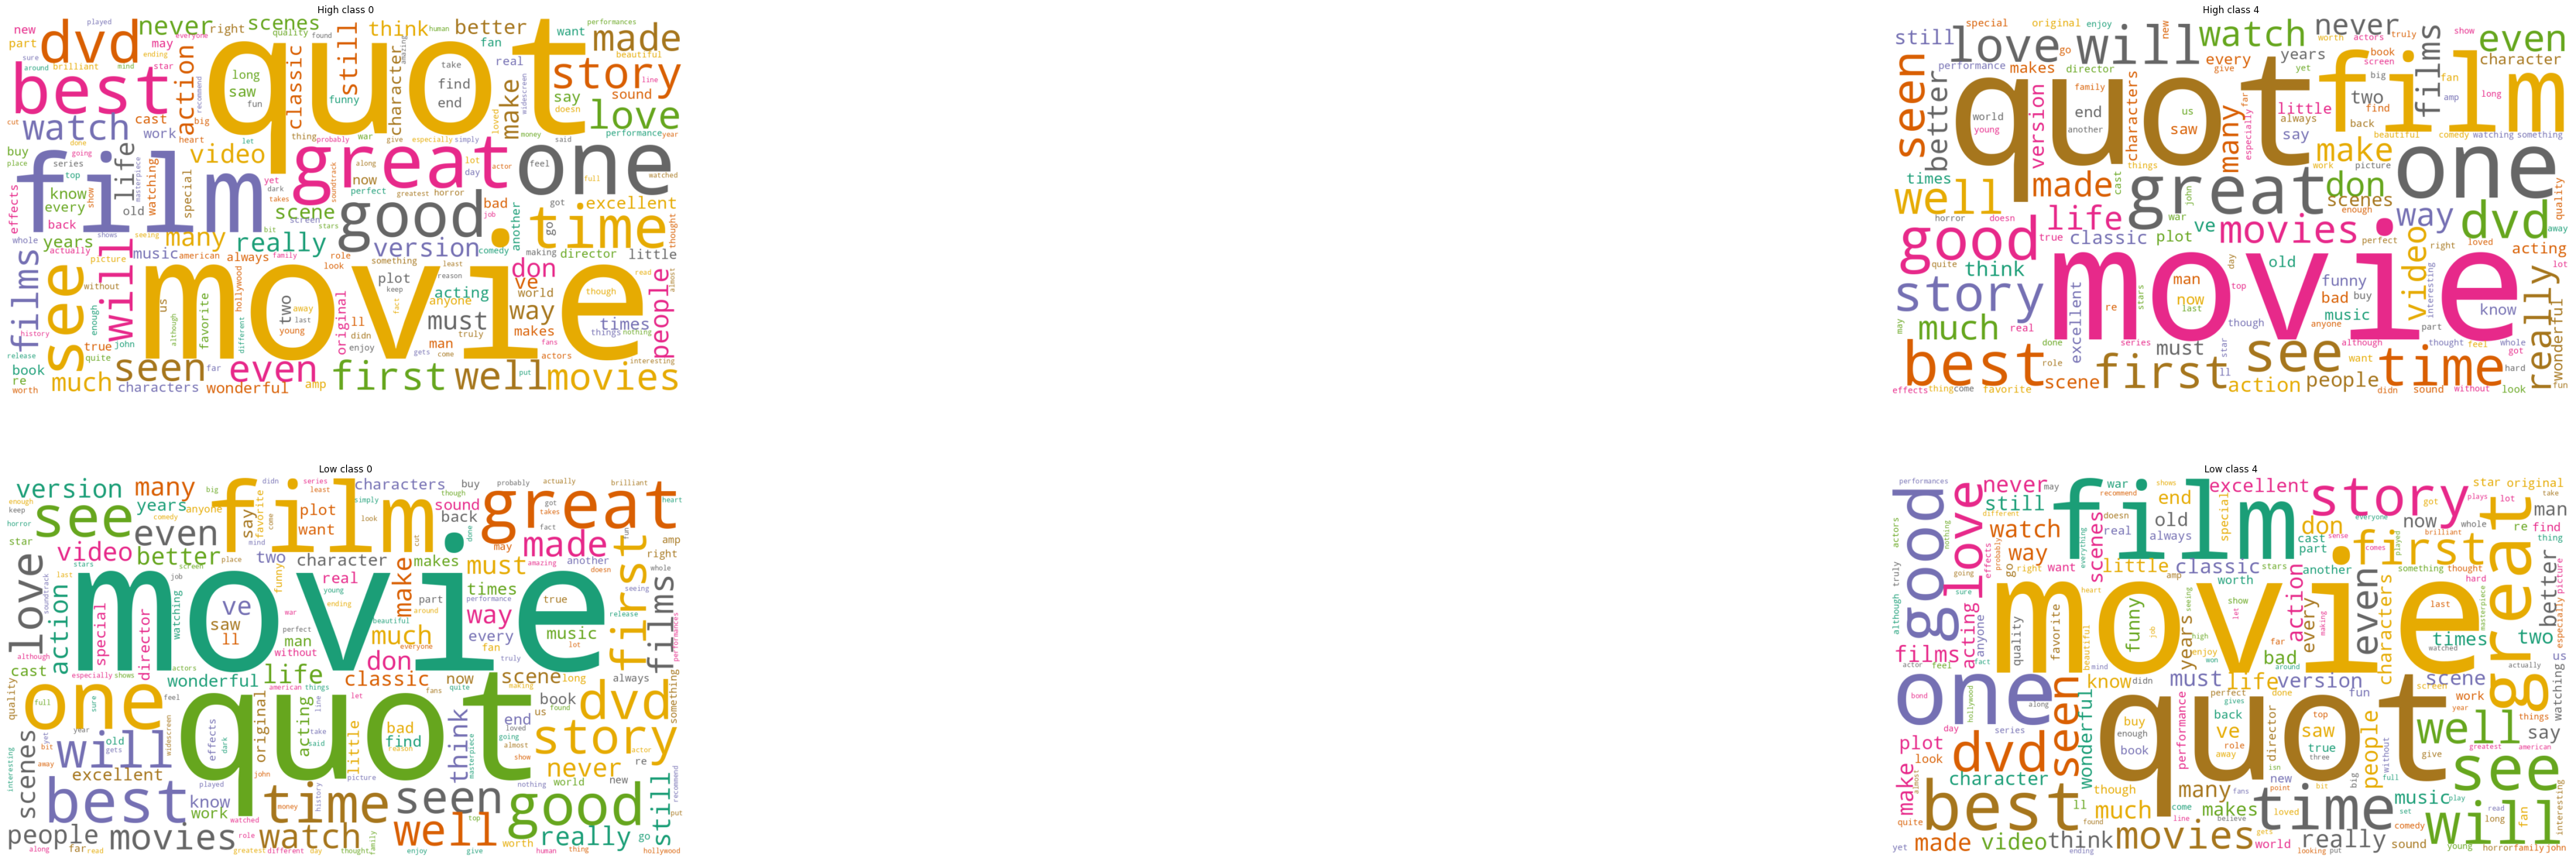

In [9]:
print_doc = False
wordcloud_plot = True
for episode, (features, targets, texts) in enumerate(zip(features_list, targets_list, text_list)):

    for run in range(random_runs):
        print("episode ", episode)
        print("------------------------------------ run ", run)

        # split and shuffel the data
        X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=test_split, shuffle=True, random_state=seed)
        _,       text_test, _   , _      = train_test_split(texts,    targets, test_size=test_split, shuffle=True, random_state=seed)

        print("test count ", len(y_test))

        # train the model
        model = RandomForestClassifier(max_depth=10, n_estimators=10, random_state=seed+run)
        model.fit(X_train, y_train[:,0]) # remove keys when fiting the model

        predictions = model.predict(X_test)
        if log:
            print("model test score = ", model.score(X_test, y_test[:,0]))

        # Aleatoric uncertianty for X_test
        total_uncertainty, epistemic_uncertainty, aleatoric_uncertainty = unc.model_uncertainty(model, X_test, X_train, y_train[:,0])

        # AR plot
        if unc_plot:
            avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test[:,0].reshape((1,-1)), total_uncertainty.reshape((1,-1)))
            plt.plot(steps, avg_acc*100)
            plt.savefig(f"./Results/AR_plot.png",bbox_inches='tight')

        # sort based on uncertianty
        sorted_index = np.argsort(-total_uncertainty, kind='stable')
        text_test = np.array(text_test)
        text_test = text_test[sorted_index]
        predictions = predictions[sorted_index]
        # epistemic_uncertainty = epistemic_uncertainty[sorted_index]

        # Get uncertainty per class
        u = np.unique(y_test[:,0]) # find the unique classes

        tokens_high_class_list = []
        tokens_low_class_list  = []
        tokens_all = None
        wordcloud = Wordcloud()

        # high and low uncertainty tokens for each class
        for class_value in u: # this loop random_runs for every class in the dataset
            index = np.where(y_test[:,0]==class_value)[0]
            unc_sorted_class_text = text_test[index]
            unc_sorted_class_prediction = predictions[index]
            
            if print_doc:
                print("------------------------------------ class ", class_value)
                print("High uncertainty >>>>")
                print(unc_sorted_class_text[0], f" [prediction {unc_sorted_class_prediction[0]}]")
                print("Low uncertainty  >>>>")
                print(unc_sorted_class_text[-1], f" [prediction {unc_sorted_class_prediction[-1]}]")

            # wordcloud_text_array = unc_sorted_class_text[:unc_embeddings]
            wordcloud_text_array = unc_sorted_class_text # to select all the documents
            tokens_high = wordcloud.get_tokens(list(wordcloud_text_array))
            tokens_high_class_list.append(tokens_high)
            print(tokens_high) # just to see the counter object

            # wordcloud_text_array = unc_sorted_class_text[-unc_embeddings:]
            wordcloud_text_array = unc_sorted_class_text # to select all the documents
            tokens_low = wordcloud.get_tokens(list(wordcloud_text_array))
            tokens_low_class_list.append(tokens_low)

            class_tokens = tokens_high + tokens_low

            if tokens_all == None:
                tokens_all = class_tokens
            else:
                tokens_all += class_tokens

        # scaling the class tokens with the overall sum
        if scaling:
            for i in range(len(u)):
                tokens = tokens_high_class_list[i]
                for item, count in tokens.items():
                    tokens[item] /= tokens_all[item]
                tokens_high_class_list[i] = tokens

                tokens = tokens_low_class_list[i]
                for item, count in tokens.items():
                    tokens[item] /= tokens_all[item]
                tokens_low_class_list[i] = tokens

        if wordcloud_plot:
            # Create wordcloud
            fig, axs = plt.subplots(2,len(u))
            fig.set_figheight(20)
            fig.set_figwidth(80)
            for i, class_value in enumerate(u):
                cloud = wordcloud.get_wordcloud(tokens_high_class_list[i])
                # axs = wordcloud.plot(cloud, f"High_class_{class_value}_e{episode}", axs=axs, axs_index=[0,i])
                axs[0][i].imshow(cloud, interpolation="bilinear")
                axs[0][i].axis("off")
                axs[0][i].set_title(f"High class {class_value}")

                cloud = wordcloud.get_wordcloud(tokens_low_class_list[i])
                # axs = wordcloud.plot(cloud, f"Low_class_{class_value}_e{episode}", axs=axs, axs_index=[1,i])
                axs[1][i].imshow(cloud, interpolation="bilinear")
                axs[1][i].axis("off")
                axs[1][i].set_title(f"Low class {class_value}")

            fig.savefig(f"./Results/ALL_episode_{episode}_r{run}.png",bbox_inches='tight') # 

    break
    
